<a href="https://colab.research.google.com/github/Raviteja654321/CVIT_Workshop/blob/main/Day_7/Day_7_ItsAboutTime_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Notebook for ItsAboutTime

Paper link: https://openaccess.thecvf.com/content/CVPR2022/papers/Yang_Its_About_Time_Analog_Clock_Reading_in_the_Wild_CVPR_2022_paper.pdf

### Get a GPU Instance

Go to Runtime -> Change Runtime Type and Select GPU as the hardware accelerator.

In [1]:
!nvidia-smi

Mon May 29 07:03:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Generate a Synthetic Dataset

### Function to generate the synthetic dataset

In [2]:
import numpy as np
import cv2
import math
import random

def truefalse(p):
	return random.random() < p

def intminmax(mi, ma):
	return random.choice(range(mi, ma+1))

def minmax(mi, ma):
	return np.random.uniform(mi,ma)

def rand_colour(p_gray=0, p_light=0, p_dark=0, p_red=0):
	xmin = 0; xmax = 255;
	gray = random.random() < p_gray
	if gray:
		x = random.choice(range(xmin,xmax))
		return (x, x, x)
	light = random.random() < p_light
	if light: 
		xmin  = 200;
		x = random.choice(range(xmin,xmax))
		return (x, x, x)
	dark = random.random() < p_dark
	if dark: 
		xmax = 100;
		x = random.choice(range(xmin,xmax))
		return (x, x, x)
	
	xmin = 50; ymin = 50; zmin = 50;
	xmax = 200; ymax = 200; zmax = 200;
	red = random.random() < p_red
	if red:
		xmin = 0; ymin = 0; zmin = 127;
		xmax = 100; ymax = 100; zmax = 255;
	x = random.choice(range(xmin,xmax))
	y = random.choice(range(ymin,ymax))
	z = random.choice(range(zmin,zmax))
	return (x, y, z)

def get_coordinates(cx, cy, r, scale, back_scale, a):
	x1 = (cx + scale*r * np.cos(a * math.pi/180)).astype(int)
	y1 = (cy + scale*r * np.sin(a * math.pi/180)).astype(int)
	x2 = (cx + back_scale*r * np.cos(a * math.pi/180)).astype(int)
	y2 = (cy + back_scale*r * np.sin(a * math.pi/180)).astype(int)
	return (x1, y1), (x2, y2)

def draw_line(img, source, dest, colour, thickness, arrow=False, arrow_scale=None, tip_length=None, shadow=False, rand=False):
	img = cv2.line(img, source, dest, colour, thickness)
	x1, y1 = source
	x2, y2 = dest

	if arrow:
		arrowhead = (int(x2 + (x1-x2) * arrow_scale), int(y2 + (y1-y2) * arrow_scale))
		img = cv2.arrowedLine(img, dest, arrowhead, colour, thickness, tipLength=tip_length)

	if shadow:
		dx = random.choice([1,-1]) * intminmax(thickness, 30)
		dy = random.choice([1,-1]) * intminmax(thickness, 30)
		shadow_colour = colour if truefalse(0.5) else rand_colour(p_dark=0.8)
		shadow_alpha = minmax(0.1,0.9)
		img_orig = img.copy()
		img_shadow = cv2.line(img, (x1+dx, y1+dy), (x2+dx, y2+dy), shadow_colour, thickness)
		img = cv2.addWeighted(img_shadow, shadow_alpha, img_orig, 1-shadow_alpha, 0)		
	return img

def draw_random_lines(img, cx, cy, r, R, num=3):
	for _ in range(num):
		r1 = intminmax(r,R)
		r2 = intminmax(r,R)
		theta1 = minmax(0, 360)
		theta2 = minmax(0, 360)
		colour = rand_colour()
		thickness = intminmax(1,10)

		x1 = (cx + r1 * np.cos(theta1 * math.pi/180)).astype(int)
		y1 = (cy + r1 * np.sin(theta1 * math.pi/180)).astype(int)
		x2 = (cx + r2 * np.cos(theta2 * math.pi/180)).astype(int)
		y2 = (cy + r2 * np.sin(theta2 * math.pi/180)).astype(int)

		img_shadow = cv2.line(img, (x1, y1), (x2, y2), colour, thickness)
	return img

def gen_clock(use_homography=False, use_artefacts=False):
	#hyperparameters:
	#canvas
	H = 448
	W = 448
	h = 392 #intminmax(384, 512)
	w = h 
	use_border = True
	canvas_background_colour = rand_colour(p_gray=0.2)
	hmax = 0.1

	#clock shape
	use_rectangle_clock = truefalse(0.25)
	clock_center_coordinates = (h//2, w//2)
	clock_border_thickness = intminmax(0, 60)
	clock_radius = (min(h,w)//2 - clock_border_thickness//2 -1)
	clock_background_colour = rand_colour(p_light=0.8) if truefalse(0.7) else rand_colour(p_gray=0.2)
	clock_border_colour = rand_colour(p_gray=0)

	#ticks (minute)
	use_rectangle_tick = truefalse(0.6) if use_rectangle_clock else False 
	use_minute_tick = truefalse(0.8)
	tick_gap = intminmax(0, 15)
	tick_length = intminmax(1, 10)
	tick_thickness = intminmax(1, 10)
	tick_colour = rand_colour(p_dark=0.5, p_gray=0.2)

	#ticks (hour)
	tick_h_gap = tick_gap
	tick_h_length = intminmax(tick_length, 15)
	tick_h_thickness = intminmax(tick_thickness, 15)
	tick_h_colour = tick_colour if truefalse(0.8) else rand_colour(p_dark=0.5, p_gray=0.2)

	#numerals
	use_numerals = truefalse(0.8)
	use_roman = truefalse(0.3)
	num_rotate = truefalse(0.3) if use_roman else truefalse(0.05)
	num_font = intminmax(0,7)
	num_font_scale = minmax(0.5,2)
	num_font_thickness = intminmax(1,4)
	num_colour = tick_colour if truefalse(0.8) else rand_colour(p_dark=0.5, p_gray=0.2)
	num_gap = intminmax(10, 40)

	#hands
	use_alarm_hand = truefalse(0.4)
	time_alarm = minmax(0, 1)
	alarm_scale = minmax(0.2, 0.5)
	alarm_back_scale = minmax(-0.1,0)
	alarm_colour = rand_colour(p_light=0.25, p_gray=0.25, p_dark=0.25)
	alarm_thickness = intminmax(1,5)

	use_second_hand = truefalse(0.5)
	time_hour = intminmax(0, 12)
	time_minute = intminmax(0, 60)
	time_second = intminmax(0, 60)
	sec_scale = minmax(0.8, 0.95)
	sec_back_scale = 0 if truefalse(0.3) else minmax(-0.3, 0)
	sec_colour = rand_colour(p_red=0.4, p_gray=0.15, p_dark=0.2)
	sec_thickness = intminmax(1,5)

	min_arrowed = truefalse(0.5)
	min_arrow_scale = minmax(0.3, 1)
	min_tip_length = minmax(0.1, 0.2)
	min_scale = minmax(0.6, sec_scale)
	min_back_scale = 0 if truefalse(0.3) else minmax(-0.3, 0)
	min_colour = rand_colour(p_dark=0.9)
	min_thickness = intminmax(5,12)

	hr_arrowed = min_arrowed
	hr_arrow_scale = min_arrow_scale
	hr_scale = minmax(0.3, min_scale)
	hr_tip_length = min_tip_length * min_scale / hr_scale
	hr_back_scale = 0 if truefalse(0.3) else minmax(-0.15, 0)
	hr_colour = min_colour if truefalse(0.8) else rand_colour(p_dark=0.9)
	hr_thickness = intminmax(min_thickness,18)

	#circle
	use_circle_border = truefalse(0.5)
	circle_radius = intminmax(8,12)
	circle_colour = rand_colour(p_dark=0.5)
	circle_border_colour = rand_colour(p_dark=0.1)
	circle_border_thickness = intminmax(1,3)

	#create background
	img = np.zeros((h, w, 3), np.uint8)
	img[:] = canvas_background_colour

	#shadow
	if use_artefacts:
		hr_shadow = truefalse(0.5)
		min_shadow = truefalse(0.5)
		sec_shadow = truefalse(0.5)
		alarm_shadow = truefalse(0.5)

		#random
		num_random_lines = intminmax(0, 5)
	else:
		hr_shadow = False
		min_shadow = False
		sec_shadow = False
		alarm_shadow = False

	#create clock
	if not use_rectangle_clock:
		img = cv2.circle(img, clock_center_coordinates, clock_radius, clock_background_colour, cv2.FILLED)
		img = cv2.circle(img, clock_center_coordinates, clock_radius, clock_border_colour, clock_border_thickness)
	else:
		img = cv2.rectangle(img, (0, 0), (h, w), clock_background_colour, cv2.FILLED)
		img = cv2.rectangle(img, (0, 0), (h, w), clock_border_colour, clock_border_thickness)

	#create ticks
	cy, cx = clock_center_coordinates
	r = clock_radius
	a = np.arange(60)*6
	acos = np.cos(a * math.pi/180)
	asin = np.sin(a * math.pi/180)
	if use_rectangle_tick:
		atan = np.tan(a * math.pi/180)
		acos[0:8] = 1 ; acos[23:38] = -1 ; acos[53:] = 1
		asin[0:8] = atan[0:8] ; asin[23:38] = atan[23:38] ; asin[53:] = atan[53:]
		asin[8:23] = -1 ; asin[38:53] = 1 ;
		acos[8:23] = 1/atan[8:23] ; acos[38:53] = 1/atan[38:53];
		
	x1 = np.rint(cx + (r-clock_border_thickness-tick_gap) * acos).astype(int)
	y1 = np.rint(cy + (r-clock_border_thickness-tick_gap) * asin).astype(int)
	x2 = np.rint(cx + (r-clock_border_thickness-tick_gap-tick_length) * acos).astype(int)
	y2 = np.rint(cy + (r-clock_border_thickness-tick_gap-tick_length) * asin).astype(int)
	h_x1 = np.rint(cx + (r-clock_border_thickness-tick_h_gap) * acos).astype(int)
	h_y1 = np.rint(cy + (r-clock_border_thickness-tick_h_gap) * asin).astype(int)
	h_x2 = np.rint(cx + (r-clock_border_thickness-tick_h_gap-tick_h_length) * acos).astype(int)
	h_y2 = np.rint(cy + (r-clock_border_thickness-tick_h_gap-tick_h_length) * asin).astype(int)
	for i in range(len(a)):
		if i % 5 == 0:
			img = cv2.line(img, (h_x1[i], h_y1[i]), (h_x2[i], h_y2[i]), tick_h_colour, tick_h_thickness)	
		elif use_minute_tick:
			img = cv2.line(img, (x1[i], y1[i]), (x2[i], y2[i]), tick_colour, tick_thickness)

	#create numerals
	if use_numerals:
		num_texts = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2, 3]
		if use_roman: num_texts = ['III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X', 'XI', 'XII', 'I', 'II', 'III']
		a2 = np.arange(12) * 30
		acos2 = np.cos(a2 * math.pi/180)
		asin2 = np.sin(a2 * math.pi/180)
		if use_rectangle_tick:
			atan2 = np.tan(a2 * math.pi/180)
			acos2[[0, 1, 11]] = 1 ; acos2[[5, 6, 7]] = -1 ;
			asin2[[0, 1, 11]] = atan2[[0, 1, 11]] ; asin2[[5,6,7]] = -atan2[[5,6,7]] ;
			asin2[[2,3,4]] = 1 ; asin2[[8,9,10]] = -1 ;
			acos2[[2,3,4]] = 1/atan2[[2,3,4]] ; acos2[[8,9,10]] = -1/atan2[[8,9,10]];
		tx = np.rint(cx + (r-clock_border_thickness-tick_h_gap-tick_h_length-num_gap) * acos2).astype(int)
		ty = np.rint(cy + (r-clock_border_thickness-tick_h_gap-tick_h_length-num_gap) * asin2).astype(int)
		for i in range(12):
			textsize = cv2.getTextSize(str(num_texts[i]), num_font, num_font_scale, num_font_thickness)[0]
			textX = tx[i] - textsize[0]//2
			textY = ty[i] + textsize[1]//2
			cv2.putText(img, str(num_texts[i]), (textX, textY), num_font, num_font_scale, num_colour, num_font_thickness)

	#hands
	alarm = time_alarm
	a_alarm = alarm * 360
	if use_alarm_hand:
		source, dest = get_coordinates(cx, cy, r, alarm_scale, alarm_back_scale, a_alarm)
		img = draw_line(img, source, dest, alarm_colour, alarm_thickness, shadow=alarm_shadow)

	second = time_second
	a_second = second * 6 - 90
	if use_second_hand:
		source, dest = get_coordinates(cx, cy, r, sec_scale, sec_back_scale, a_second)
		img = draw_line(img, source, dest, sec_colour, sec_thickness, shadow=sec_shadow)

	minute = time_minute + second/60
	a_minute = minute * 6 - 90
	source, dest = get_coordinates(cx, cy, r, min_scale, min_back_scale, a_minute)
	img = draw_line(img, source, dest, min_colour, min_thickness, min_arrowed, min_arrow_scale, min_tip_length, shadow=min_shadow)

	hour = time_hour + minute/60
	a_hour = hour * 30 - 90
	source, dest = get_coordinates(cx, cy, r, hr_scale, hr_back_scale, a_hour)
	img = draw_line(img, source, dest, hr_colour, hr_thickness, hr_arrowed, hr_arrow_scale, hr_tip_length, shadow=hr_shadow)
	
	if use_artefacts:
		img = draw_random_lines(img, cx, cy, circle_radius, r, num=num_random_lines)

	#circle
	img = cv2.circle(img, clock_center_coordinates, circle_radius, circle_colour, cv2.FILLED)
	if use_circle_border:
		img = cv2.circle(img, clock_center_coordinates, circle_radius, circle_border_colour, circle_border_thickness)

	if use_border:
		IMG = np.zeros((H, W, 3), np.uint8)
		IMG[:] = canvas_background_colour
		Iy = (H-h)//2
		Ix = (W-w)//2
		IMG[Iy:Iy+h, Ix:Ix+w, :] = img
		img = IMG

	if use_homography:
		points = np.array(((Ix,Iy), (Ix+w,Iy), (Ix,Iy+h), (Ix+w,Iy+h)), dtype=np.float32)
		f = 4
		purturb = np.random.randint(-Ix*f,Ix*f+1,(4,2)).astype(np.float32)
		points2 = points + purturb
		M = cv2.getPerspectiveTransform(points, points2)
		img = cv2.warpPerspective(img, M, (H, W), borderValue=canvas_background_colour)
		Minv = cv2.findHomography(points2*2/448-1, points*2/448-1)[0]
		
	else:
		Minv = np.array([[1.,0,0],[0,1.,0],[0,0,1.]]).astype(np.float32)

	return img, time_hour, time_minute, Minv

### Let's see some sample images

Run this cell multiple times to see the type of clocks the synthetic data generator can generate

Hour:  8
Minutes:  14


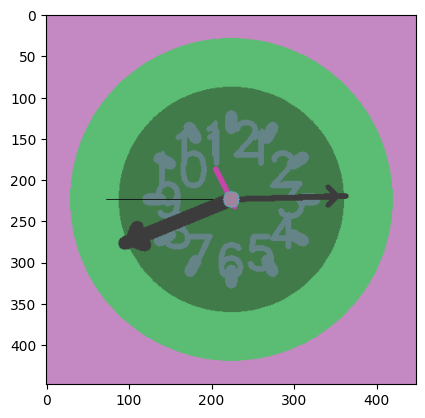

In [3]:
# Generating sample images
import matplotlib.pyplot as plt
img, time_hour, time_minute, Minv = gen_clock()
plt.imshow(img)
print ("Hour: ", time_hour)
print ("Minutes: ", time_minute)


### Creating the label for an image of the clock.

There will be 720 labels in total. This is because, there are 12 hours that can be depicted in a analog clock and each hour can have 16 minutes. We will therefore create a python dictionary which will have a label for each possible time that can be depicted in the clock. The keys will be the time and the values will be the labels ({time:label}).

In [4]:
# We will use a double loop to get the time and labels.

# Label counter. The value of the counter will become the label
counter = 0

# Dictionary for storing the {time:label}
# We will store the time as a string for easy operations.
label_dict = {}

# Loop for the hours. It can range from 1 to 12...
for i in range(1, 13):
  # Loop for the minutes. It can range from 0 to 59...
  for j in range(0, 60):

    # Converting the time into string for easier operations
    time = str(i).zfill(2) + str(j).zfill(2)
    label_dict[time] = counter

    counter += 1

print ("The label dictionary looks like this: ", label_dict)

print ("The number of labels in our dataset: ", len(label_dict))





The label dictionary looks like this:  {'0100': 0, '0101': 1, '0102': 2, '0103': 3, '0104': 4, '0105': 5, '0106': 6, '0107': 7, '0108': 8, '0109': 9, '0110': 10, '0111': 11, '0112': 12, '0113': 13, '0114': 14, '0115': 15, '0116': 16, '0117': 17, '0118': 18, '0119': 19, '0120': 20, '0121': 21, '0122': 22, '0123': 23, '0124': 24, '0125': 25, '0126': 26, '0127': 27, '0128': 28, '0129': 29, '0130': 30, '0131': 31, '0132': 32, '0133': 33, '0134': 34, '0135': 35, '0136': 36, '0137': 37, '0138': 38, '0139': 39, '0140': 40, '0141': 41, '0142': 42, '0143': 43, '0144': 44, '0145': 45, '0146': 46, '0147': 47, '0148': 48, '0149': 49, '0150': 50, '0151': 51, '0152': 52, '0153': 53, '0154': 54, '0155': 55, '0156': 56, '0157': 57, '0158': 58, '0159': 59, '0200': 60, '0201': 61, '0202': 62, '0203': 63, '0204': 64, '0205': 65, '0206': 66, '0207': 67, '0208': 68, '0209': 69, '0210': 70, '0211': 71, '0212': 72, '0213': 73, '0214': 74, '0215': 75, '0216': 76, '0217': 77, '0218': 78, '0219': 79, '0220': 80

### Generate the train, val and test sets

Let us now create the train, val and test sets using this synthetic data generator. We will keep 1000 samples for train set, 50 samples for dev and 50 samples for the test set. We will also merge the hours and minutes to get the labels. There will be 720 labels in total because the clock can diplay 12 hours and each hour has 60 minutes. 

In [5]:
def create_samples(N=1000, label_dict=label_dict):
  imgs = []
  labels = []

  cnt = 0

  while(1):
    img, time_hour, time_min, Minv = gen_clock()
    time = str(time_hour).zfill(2) + str(time_min).zfill(2)

    try:
      label = label_dict[time]

    except:

      # The time generated by the synthetic network is at times wrong. We don't consider them
      continue


    imgs.append(img)
    labels.append(label)

    cnt = cnt + 1

    if cnt == N:
      break

  return imgs, labels

In [6]:
n_train = 1000
n_val = 50
n_test = 50

train_images, train_labels = create_samples(n_train)

val_images, val_labels = create_samples(n_val)

test_images, test_labels = create_samples(n_test)

print ("All the datasets are created...")

print ("Length of the train set: ", len(train_images))
print ("Length of the test set: ", len(test_images))

All the datasets are created...
Length of the train set:  1000
Length of the test set:  50


In [7]:
print(len(set(train_labels)), len(set(test_labels)), len(set(val_labels)))

557 46 46


In [8]:
len(set(train_labels).intersection(set(test_labels)))

34

0 (448, 448, 3)


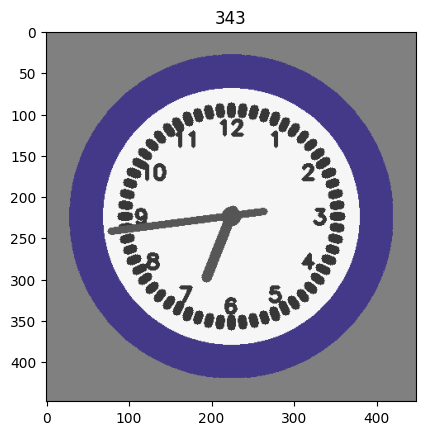

1 (448, 448, 3)


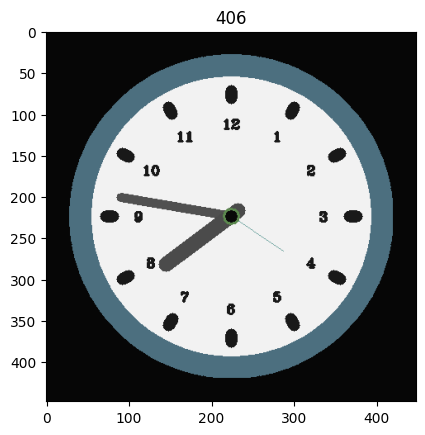

2 (448, 448, 3)


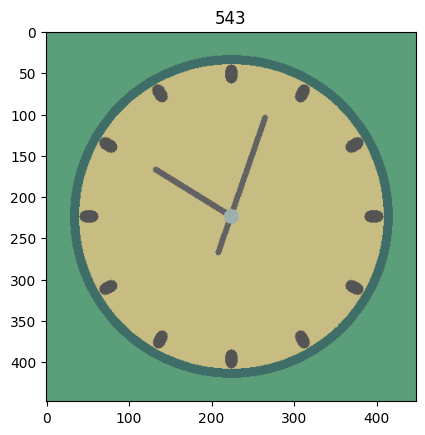

3 (448, 448, 3)


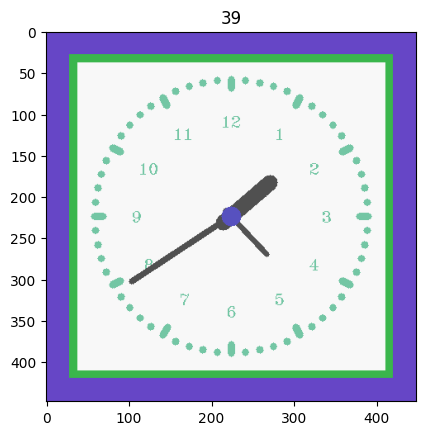

4 (448, 448, 3)


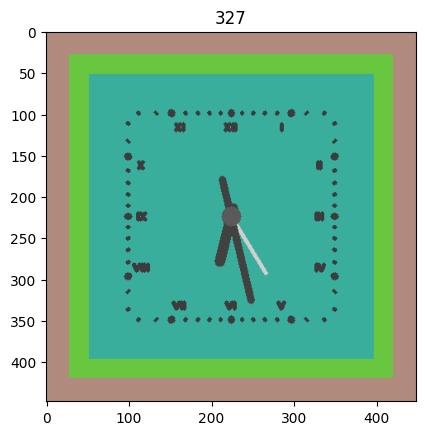

5 (448, 448, 3)


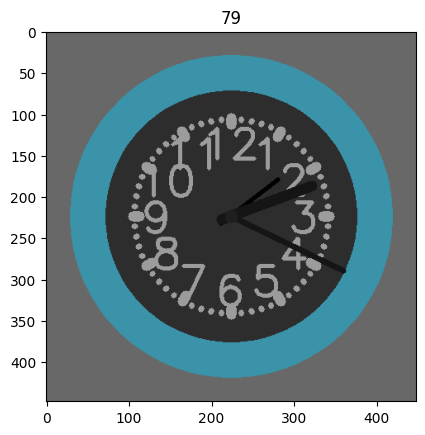

In [9]:
for i,img in enumerate(train_images):
    print(i, img.shape)
    plt.imshow(img)
    plt.title(train_labels[i])
    plt.show()
    if(i==5):
        break

In [10]:
train_data = [(cv2.resize(img,(448,448)), train_labels[i]) for i, img in enumerate(train_images)]
val_data = [(cv2.resize(img,(448,448)), val_labels[i]) for i, img in enumerate(val_images)]
test_data = [(cv2.resize(img,(448,448)), test_labels[i]) for i, img in enumerate(test_images)]

print("Train : ", len(train_data))
print("Val : ", len(val_data))
print("Test : ", len(test_data))

Train :  1000
Val :  50
Test :  50


## Create the Neural Network

In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score

### Defining the model

In [12]:
class MLPModel(torch.nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(448 * 448 * 3, 256)
        self.fc2 = torch.nn.Linear(256, 720)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Data Loader

In [13]:
class ImageDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, label = self.data[idx]
        return image.flatten(), label

### Training and validation loop

100%|██████████| 50/50 [00:00<00:00, 102.13it/s]


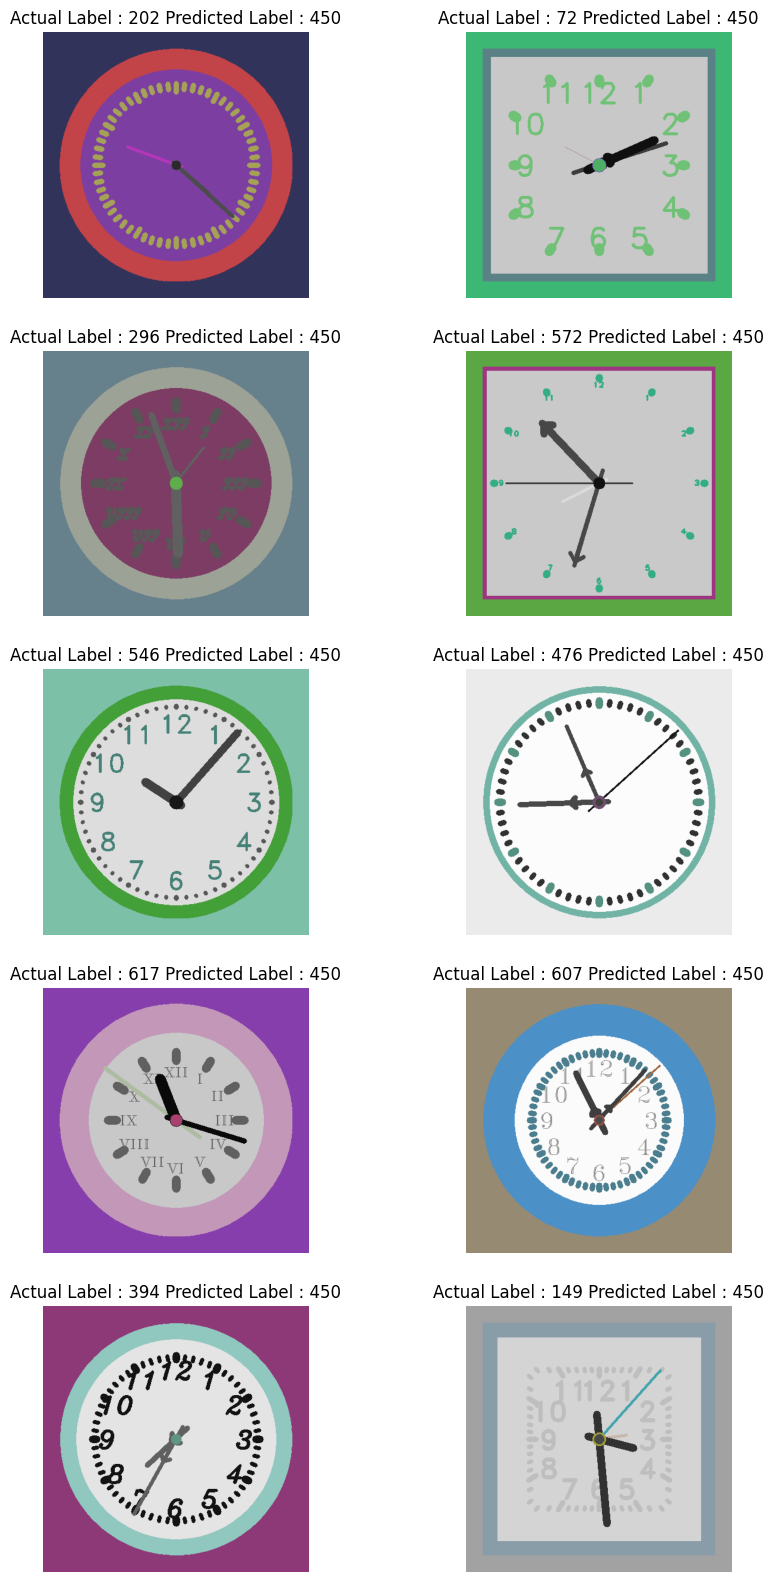

Accuracy =  0.0


In [14]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_epoch(epoch, num_epochs, data_loader,model,optimizer,criterion):
    
    total_loss = 0.0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    model.train()
    for i, (data, label) in progress_bar:
        data = data.type(torch.FloatTensor)
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad()
        pred_label = model.forward(data)
        loss = criterion(pred_label, label)
        loss.backward()
        optimizer.step()
        total_loss +=loss.item()
        progress_bar.set_description(f"Epoch = {epoch+1} Training Loss = {total_loss / (i + 1):.4f}")
        progress_bar.refresh()

def val_epoch(epoch, num_epochs, data_loader,model,optimizer,criterion):
    
    total_loss = 0.0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    model.eval()
    with torch.no_grad():
        for i, (data, label) in progress_bar:
            data = data.type(torch.FloatTensor)
            data = data.to(device)
            label = label.to(device)
            pred_label = model.forward(data)
            loss = criterion(pred_label, label)
            total_loss +=loss.item()
            progress_bar.set_description(f"Epoch = {epoch+1} Validation Loss = {total_loss / (i + 1):.4f}")
            progress_bar.refresh()
            

def test_epoch(data_loader,model):
    
    total_loss = 0.0
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader))
    model.eval()
    actual_labels = []
    predicted_labels = []
    plt.figure(figsize=(10,20))
    with torch.no_grad():
        for i, (data, label) in progress_bar:
            data = data.type(torch.FloatTensor)
            data = data.to(device)
            label = label.to(device)
            pred_label = model.forward(data)
            data = torch.reshape(data,(448,448,3))
            data = data.type(torch.LongTensor)
            data = data.detach().cpu().numpy()
            if(i<10):
                plt.subplot(5,2,i+1)
                plt.imshow(data)
                plt.title("Actual Label : {} Predicted Label : {}".format(label.item(), pred_label.argmax()))
                plt.axis("off")
            actual_labels.append(label.cpu().item())
            predicted_labels.append(pred_label.cpu().argmax())
        plt.show()
    print("Accuracy = ", accuracy_score(actual_labels, predicted_labels))
        

def main():
    batch_size=32
    train_loader = DataLoader(ImageDataset(train_data), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(ImageDataset(val_data), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(ImageDataset(test_data), batch_size=1, shuffle=False)
    model = MLPModel()
    model = model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    learning_rate = 0.001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs=1
    epoch=0
    while(epoch<num_epochs):
        train_epoch(epoch=epoch, num_epochs=num_epochs, data_loader=train_loader, model=model, optimizer=optimizer,criterion=criterion)
        val_epoch(epoch=epoch, num_epochs=num_epochs, data_loader=train_loader, model=model, optimizer=optimizer,criterion=criterion)
        epoch+=1
    
    test_epoch(data_loader=test_loader, model=model)

main()